In [42]:
import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore')

# Parts of Speech (POS) Tagging

In [2]:
sentence = "US unveils world's most powerful supercomputer, beats China."

import pandas as pd
import spacy
nlp = spacy.load('en_core', parse=True, tag=True, entity=True)
sentence_nlp = nlp(sentence)
# POS tagging with Spacy 
spacy_pos_tagged = [(word, word.tag_, word.pos_) for word in sentence_nlp]
pd.DataFrame(spacy_pos_tagged, columns=['Word', 'POS tag', 'Tag type']).T

,0,1,2,3,4,5,6,7,8,9,10
Word,US,unveils,world,'s,most,powerful,supercomputer,",",beats,China,.
POS tag,NNP,VBZ,NN,POS,RBS,JJ,NN,",",VBZ,NNP,.
Tag type,PROPN,VERB,NOUN,PART,ADV,ADJ,NOUN,PUNCT,VERB,PROPN,PUNCT


In [3]:
# POS tagging with nltk
import nltk
nltk_pos_tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
pd.DataFrame(nltk_pos_tagged, columns=['Word', 'POS tag']).T

,0,1,2,3,4,5,6,7,8,9,10
Word,US,unveils,world,'s,most,powerful,supercomputer,",",beats,China,.
POS tag,NNP,JJ,NN,POS,RBS,JJ,NN,",",VBZ,NNP,.


In [4]:
from nltk.corpus import treebank
data = treebank.tagged_sents()
train_data = data[:3500]
test_data = data[3500:]
print(train_data[0])

[('Pierre', 'NNP'), ('Vinken', 'NNP'), (',', ','), ('61', 'CD'), ('years', 'NNS'), ('old', 'JJ'), (',', ','), ('will', 'MD'), ('join', 'VB'), ('the', 'DT'), ('board', 'NN'), ('as', 'IN'), ('a', 'DT'), ('nonexecutive', 'JJ'), ('director', 'NN'), ('Nov.', 'NNP'), ('29', 'CD'), ('.', '.')]


In [5]:
# default tagger
from nltk.tag import DefaultTagger
dt = DefaultTagger('NN')

In [6]:
# accuracy on test data
dt.evaluate(test_data)

0.1454158195372253

In [7]:
# tagging our sample headline
dt.tag(nltk.word_tokenize(sentence))

[('US', 'NN'),
 ('unveils', 'NN'),
 ('world', 'NN'),
 ("'s", 'NN'),
 ('most', 'NN'),
 ('powerful', 'NN'),
 ('supercomputer', 'NN'),
 (',', 'NN'),
 ('beats', 'NN'),
 ('China', 'NN'),
 ('.', 'NN')]

In [8]:
# regex tagger
from nltk.tag import RegexpTagger
# define regex tag patterns
patterns = [
        (r'.*ing$', 'VBG'),               # gerunds
        (r'.*ed$', 'VBD'),                # simple past
        (r'.*es$', 'VBZ'),                # 3rd singular present
        (r'.*ould$', 'MD'),               # modals
        (r'.*\'s$', 'NN$'),               # possessive nouns
        (r'.*s$', 'NNS'),                 # plural nouns
        (r'^-?[0-9]+(.[0-9]+)?$', 'CD'),  # cardinal numbers
        (r'.*', 'NN')                     # nouns (default) ... 
]
rt = RegexpTagger(patterns)

In [9]:
# accuracy on test data
rt.evaluate(test_data)

0.24039113176493368

In [10]:
# tagging our sample headline
rt.tag(nltk.word_tokenize(sentence))

[('US', 'NN'),
 ('unveils', 'NNS'),
 ('world', 'NN'),
 ("'s", 'NN$'),
 ('most', 'NN'),
 ('powerful', 'NN'),
 ('supercomputer', 'NN'),
 (',', 'NN'),
 ('beats', 'NNS'),
 ('China', 'NN'),
 ('.', 'NN')]

In [11]:
## N gram taggers
from nltk.tag import UnigramTagger
from nltk.tag import BigramTagger
from nltk.tag import TrigramTagger

ut = UnigramTagger(train_data)
bt = BigramTagger(train_data)
tt = TrigramTagger(train_data)

In [12]:
# testing performance of unigram tagger
print(ut.evaluate(test_data))
print(ut.tag(nltk.word_tokenize(sentence)))

0.8609739568206022
[('US', 'NNP'), ('unveils', None), ('world', 'NN'), ("'s", 'POS'), ('most', 'JJS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', None), ('China', 'NNP'), ('.', '.')]


In [13]:
# testing performance of bigram tagger
print(bt.evaluate(test_data))
print(bt.tag(nltk.word_tokenize(sentence)))

0.13563752541388324
[('US', None), ('unveils', None), ('world', None), ("'s", None), ('most', None), ('powerful', None), ('supercomputer', None), (',', None), ('beats', None), ('China', None), ('.', None)]


In [14]:
# testing performance of trigram tagger
print(tt.evaluate(test_data))
print(tt.tag(nltk.word_tokenize(sentence)))

0.0813244263723497
[('US', None), ('unveils', None), ('world', None), ("'s", None), ('most', None), ('powerful', None), ('supercomputer', None), (',', None), ('beats', None), ('China', None), ('.', None)]


In [15]:
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

ct = combined_tagger(train_data=train_data, 
                     taggers=[UnigramTagger, BigramTagger, TrigramTagger],
                     backoff=rt)

In [16]:
# evaluating the new combined tagger with backoff taggers
print(ct.evaluate(test_data))      
print(ct.tag(nltk.word_tokenize(sentence)))

0.9104463161971149
[('US', 'NNP'), ('unveils', 'NNS'), ('world', 'NN'), ("'s", 'POS'), ('most', 'JJS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', 'NNS'), ('China', 'NNP'), ('.', '.')]


In [17]:
from nltk.classify import NaiveBayesClassifier, MaxentClassifier
from nltk.tag.sequential import ClassifierBasedPOSTagger

nbt = ClassifierBasedPOSTagger(train=train_data,
                               classifier_builder=NaiveBayesClassifier.train)

In [18]:
# evaluate tagger on test data and sample sentence
print(nbt.evaluate(test_data))
print(nbt.tag(nltk.word_tokenize(sentence)))

0.9306806079969019
[('US', 'PRP'), ('unveils', 'VBZ'), ('world', 'VBN'), ("'s", 'POS'), ('most', 'JJS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', 'VBZ'), ('China', 'NNP'), ('.', '.')]


In [19]:
# try this out for fun!
#met = ClassifierBasedPOSTagger(train=train_data,
#                               classifier_builder=MaxentClassifier.train)
#print(met.evaluate(test_data))                           
#print(met.tag(nltk.word_tokenize(sentence)))

# Shallow Parsing or Chunking

In [20]:
from nltk.corpus import treebank_chunk
data = treebank_chunk.chunked_sents()

train_data = data[:3500]
test_data = data[3500:]
# view sample data
print(train_data[7])

(S
  (NP A/DT Lorillard/NNP spokewoman/NN)
  said/VBD
  ,/,
  ``/``
  (NP This/DT)
  is/VBZ
  (NP an/DT old/JJ story/NN)
  ./.)


In [21]:
from nltk.chunk import RegexpParser

# get POS tagged sentence
tagged_simple_sent = nltk.pos_tag(nltk.word_tokenize(sentence))
print('POS Tags:', tagged_simple_sent)

# illustrate NP chunking based on explicit chunk patterns
chunk_grammar = """
NP: {<DT>?<JJ>*<NN.*>}
"""
rc = RegexpParser(chunk_grammar)
c = rc.parse(tagged_simple_sent)

POS Tags: [('US', 'NNP'), ('unveils', 'JJ'), ('world', 'NN'), ("'s", 'POS'), ('most', 'RBS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', 'VBZ'), ('China', 'NNP'), ('.', '.')]


(S
  (NP US/NNP)
  (NP unveils/JJ world/NN)
  's/POS
  most/RBS
  (NP powerful/JJ supercomputer/NN)
  ,/,
  beats/VBZ
  (NP China/NNP)
  ./.)


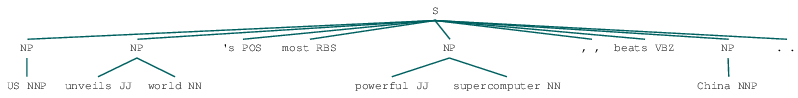

In [22]:
# print and view chunked sentence using chunking
print(c)
c

In [23]:
# illustrate NP chunking based on explicit chink patterns
chink_grammar = """
NP:
    {<.*>+}             # Chunk everything as NP
    }<VBZ|VBD|JJ|IN>+{  # Chink sequences of VBD\VBZ\JJ\IN
"""
rc = RegexpParser(chink_grammar)
c = rc.parse(tagged_simple_sent)

(S
  (NP US/NNP)
  unveils/JJ
  (NP world/NN 's/POS most/RBS)
  powerful/JJ
  (NP supercomputer/NN ,/,)
  beats/VBZ
  (NP China/NNP ./.))


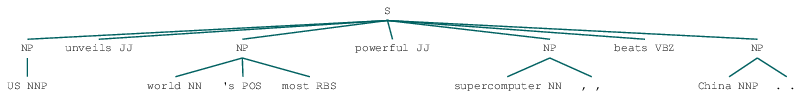

In [24]:
# print and view chunked sentence using chinking
print(c)
c

In [25]:
# create a more generic shallow parser
grammar = """
NP: {<DT>?<JJ>?<NN.*>}  
ADJP: {<JJ>}
ADVP: {<RB.*>}
PP: {<IN>}      
VP: {<MD>?<VB.*>+}
"""
rc = RegexpParser(grammar)
c = rc.parse(tagged_simple_sent)

(S
  (NP US/NNP)
  (NP unveils/JJ world/NN)
  's/POS
  (ADVP most/RBS)
  (NP powerful/JJ supercomputer/NN)
  ,/,
  (VP beats/VBZ)
  (NP China/NNP)
  ./.)


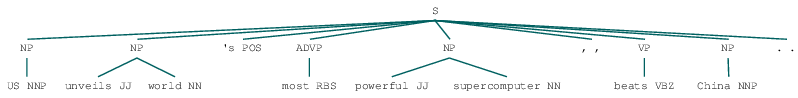

In [26]:
# print and view shallow parsed sample sentence
print(c)
c

In [27]:
# Evaluate parser performance on test data
print(rc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  46.1%%
    Precision:     19.9%%
    Recall:        43.3%%
    F-Measure:     27.3%%


In [28]:
from nltk.chunk.util import tree2conlltags, conlltags2tree
# look at a sample training tagged sentence
train_sent = train_data[7]
print(train_sent)

(S
  (NP A/DT Lorillard/NNP spokewoman/NN)
  said/VBD
  ,/,
  ``/``
  (NP This/DT)
  is/VBZ
  (NP an/DT old/JJ story/NN)
  ./.)


In [29]:
# get the (word, POS tag, Chunk tag) triples for each token
wtc = tree2conlltags(train_sent)
wtc

[('A', 'DT', 'B-NP'),
 ('Lorillard', 'NNP', 'I-NP'),
 ('spokewoman', 'NN', 'I-NP'),
 ('said', 'VBD', 'O'),
 (',', ',', 'O'),
 ('``', '``', 'O'),
 ('This', 'DT', 'B-NP'),
 ('is', 'VBZ', 'O'),
 ('an', 'DT', 'B-NP'),
 ('old', 'JJ', 'I-NP'),
 ('story', 'NN', 'I-NP'),
 ('.', '.', 'O')]

In [30]:
# get shallow parsed tree back from the WTC triples
tree = conlltags2tree(wtc)
print(tree)

(S
  (NP A/DT Lorillard/NNP spokewoman/NN)
  said/VBD
  ,/,
  ``/``
  (NP This/DT)
  is/VBZ
  (NP an/DT old/JJ story/NN)
  ./.)


In [31]:
def conll_tag_chunks(chunk_sents):
  tagged_sents = [tree2conlltags(tree) for tree in chunk_sents]
  return [[(t, c) for (w, t, c) in sent] for sent in tagged_sents]
  
def combined_tagger(train_data, taggers, backoff=None):
    for tagger in taggers:
        backoff = tagger(train_data, backoff=backoff)
    return backoff

In [32]:
from nltk.tag import UnigramTagger, BigramTagger
from nltk.chunk import ChunkParserI

class NGramTagChunker(ChunkParserI):
    
  def __init__(self, train_sentences, 
               tagger_classes=[UnigramTagger, BigramTagger]):
    train_sent_tags = conll_tag_chunks(train_sentences)
    self.chunk_tagger = combined_tagger(train_sent_tags, tagger_classes)

  def parse(self, tagged_sentence):
    if not tagged_sentence: 
        return None
    pos_tags = [tag for word, tag in tagged_sentence]
    chunk_pos_tags = self.chunk_tagger.tag(pos_tags)
    chunk_tags = [chunk_tag for (pos_tag, chunk_tag) in chunk_pos_tags]
    wpc_tags = [(word, pos_tag, chunk_tag) for ((word, pos_tag), chunk_tag)
                     in zip(tagged_sentence, chunk_tags)]
    return conlltags2tree(wpc_tags)

In [33]:
# train the shallow parser
ntc = NGramTagChunker(train_data)

# test parser performance on test data
print(ntc.evaluate(test_data))

ChunkParse score:
    IOB Accuracy:  97.2%%
    Precision:     91.4%%
    Recall:        94.3%%
    F-Measure:     92.8%%


(S
  (NP US/NNP)
  unveils/VBZ
  (NP world/NN 's/POS most/RBS powerful/JJ supercomputer/NN)
  ,/,
  beats/VBZ
  (NP China/NNP)
  ./.)


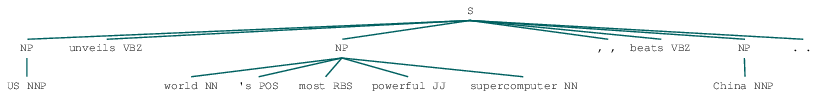

In [34]:
# parse our sample sentence
sentence_nlp = nlp(sentence)
tagged_sentence = [(word.text, word.tag_) for word in sentence_nlp]
tree = ntc.parse(tagged_sentence)
print(tree)
tree

In [35]:
from nltk.corpus import conll2000
wsj_data = conll2000.chunked_sents()
train_wsj_data = wsj_data[:10000]
test_wsj_data = wsj_data[10000:]
# look at a sample sentence in the corpus
print(train_wsj_data[10])

(S
  (NP He/PRP)
  (VP reckons/VBZ)
  (NP the/DT current/JJ account/NN deficit/NN)
  (VP will/MD narrow/VB)
  (PP to/TO)
  (NP only/RB #/# 1.8/CD billion/CD)
  (PP in/IN)
  (NP September/NNP)
  ./.)


In [36]:
# train the shallow parser
tc = NGramTagChunker(train_wsj_data)

# test performance on the test data
print(tc.evaluate(test_wsj_data))

ChunkParse score:
    IOB Accuracy:  89.1%%
    Precision:     80.3%%
    Recall:        86.1%%
    F-Measure:     83.1%%


(S
  (NP US/NNP)
  (VP unveils/VBZ)
  (NP world/NN)
  (NP 's/POS most/RBS powerful/JJ supercomputer/NN)
  ,/,
  (VP beats/VBZ)
  (NP China/NNP)
  ./.)


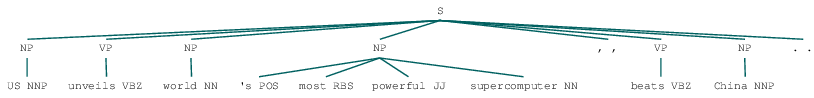

In [37]:
# parse our sample sentence
tree = tc.parse(tagged_sentence)
print(tree)
tree

# Dependency Parsing

In [38]:
dependency_pattern = '{left}<---{word}[{w_type}]--->{right}\n--------'
for token in sentence_nlp:
    print(dependency_pattern.format(word=token.orth_, 
                                  w_type=token.dep_,
                                  left=[t.orth_ 
                                            for t 
                                            in token.lefts],
                                  right=[t.orth_ 
                                             for t 
                                             in token.rights]))

[]<---US[nsubj]--->[]
--------
['US']<---unveils[ROOT]--->['supercomputer', ',', 'beats', '.']
--------
[]<---world[poss]--->["'s"]
--------
[]<---'s[case]--->[]
--------
[]<---most[advmod]--->[]
--------
['most']<---powerful[amod]--->[]
--------
['world', 'powerful']<---supercomputer[dobj]--->[]
--------
[]<---,[punct]--->[]
--------
[]<---beats[conj]--->['China']
--------
[]<---China[dobj]--->[]
--------
[]<---.[punct]--->[]
--------


In [46]:
from spacy import displacy

displacy.render(sentence_nlp, jupyter=True, 
                options={'distance': 110,
                         'arrow_stroke': 2,
                         'arrow_width': 8})

C:\Program Files\Anaconda3\lib\runpy.py:184: DeprecationWarning: Positional arguments to Doc.merge are deprecated. Instead, use the keyword arguments, for example tag=, lemma= or ent_type=.
  "__main__", mod_spec)
C:\Program Files\Anaconda3\lib\runpy.py:184: DeprecationWarning: Positional arguments to Doc.merge are deprecated. Instead, use the keyword arguments, for example tag=, lemma= or ent_type=.
  "__main__", mod_spec)


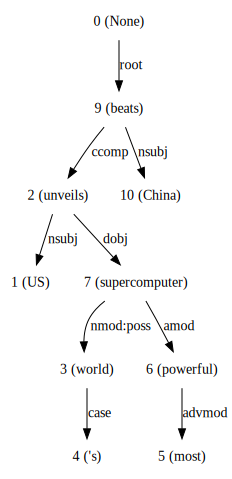

In [48]:
from nltk.parse.stanford import StanfordDependencyParser
sdp = StanfordDependencyParser(path_to_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                               path_to_models_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')    

# perform dependency parsing
result = list(sdp.raw_parse(sentence))[0]  

# generate annotated dependency parse tree
result

In [49]:
# generate dependency triples
[item for item in result.triples()]

[(('beats', 'VBZ'), 'ccomp', ('unveils', 'VBZ')),
 (('unveils', 'VBZ'), 'nsubj', ('US', 'NNP')),
 (('unveils', 'VBZ'), 'dobj', ('supercomputer', 'NN')),
 (('supercomputer', 'NN'), 'nmod:poss', ('world', 'NN')),
 (('world', 'NN'), 'case', ("'s", 'POS')),
 (('supercomputer', 'NN'), 'amod', ('powerful', 'JJ')),
 (('powerful', 'JJ'), 'advmod', ('most', 'RBS')),
 (('beats', 'VBZ'), 'nsubj', ('China', 'NNP'))]

In [52]:
# print simple dependency parse tree
dep_tree = result.tree()
print(dep_tree)

(beats (unveils US (supercomputer (world 's) (powerful most))) China)


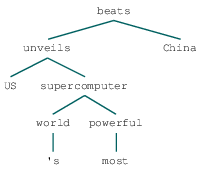

In [53]:
# visualize simple dependency parse tree
dep_tree

# Constituency Parsing

In [83]:
# set java path
import os
java_path = r'C:\Program Files\Java\jdk1.8.0_102\bin\java.exe'
os.environ['JAVAHOME'] = java_path

# create parser object
from nltk.parse.stanford import StanfordParser
scp = StanfordParser(path_to_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser.jar',
                     path_to_models_jar='E:/stanford/stanford-parser-full-2015-04-20/stanford-parser-3.5.2-models.jar')

# get parse tree                   
result = list(scp.raw_parse(sentence))[0]
# print the constituency parse tree
print(result)

(ROOT
  (SINV
    (S
      (NP (NNP US))
      (VP
        (VBZ unveils)
        (NP
          (NP (NN world) (POS 's))
          (ADJP (RBS most) (JJ powerful))
          (NN supercomputer))))
    (, ,)
    (VP (VBZ beats))
    (NP (NNP China))
    (. .)))


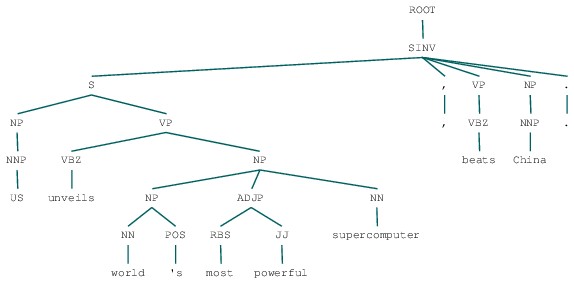

In [84]:
# visualize the parse tree
from IPython.display import display
display(result)

In [85]:
import nltk
from nltk.grammar import Nonterminal
from nltk.corpus import treebank
# load and view training data
training_set = treebank.parsed_sents()
print(training_set[1])                

(S
  (NP-SBJ (NNP Mr.) (NNP Vinken))
  (VP
    (VBZ is)
    (NP-PRD
      (NP (NN chairman))
      (PP
        (IN of)
        (NP
          (NP (NNP Elsevier) (NNP N.V.))
          (, ,)
          (NP (DT the) (NNP Dutch) (VBG publishing) (NN group))))))
  (. .))


In [86]:
# extract the productions for all annotated training sentences
treebank_productions = list(
                        set(production 
                            for sent in training_set  
                            for production in sent.productions()
                        )
                    )
# view some production rules
treebank_productions[0:10]

[VP -> VB NP-2 PP-CLR ADVP-MNR,
 NNS -> 'foods',
 NNP -> 'Joanne',
 JJ -> 'state-owned',
 VP -> VBN PP-LOC,
 NN -> 'turmoil',
 SBAR -> WHNP-240 S,
 QP -> DT VBN CD TO CD,
 NN -> 'cultivation',
 NNP -> 'Graham']

In [92]:
# add productions for each word, POS tag
for word, tag in treebank.tagged_words():
    t = nltk.Tree.fromstring("("+ tag + " " + word  +")")
    for production in t.productions():
        treebank_productions.append(production)

# build the PCFG based grammar  
treebank_grammar = nltk.grammar.induce_pcfg(Nonterminal('S'), 
                                         treebank_productions)

In [87]:
# build the parser
viterbi_parser = nltk.ViterbiParser(treebank_grammar)

# get sample sentence tokens
tokens = nltk.word_tokenize(sentence)

# get parse tree for sample sentence
result = list(viterbi_parser.parse(tokens))

ValueError: Grammar does not cover some of the input words: "'unveils', 'beats'".

In [89]:
# get tokens and their POS tags and check it
tagged_sent = nltk.pos_tag(nltk.word_tokenize(sentence))
print(tagged_sent)

[('US', 'NNP'), ('unveils', 'JJ'), ('world', 'NN'), ("'s", 'POS'), ('most', 'RBS'), ('powerful', 'JJ'), ('supercomputer', 'NN'), (',', ','), ('beats', 'VBZ'), ('China', 'NNP'), ('.', '.')]


In [90]:
# extend productions for sample sentence tokens
for word, tag in tagged_sent:
    t = nltk.Tree.fromstring("("+ tag + " " + word  +")")
    for production in t.productions():
        treebank_productions.append(production)

# rebuild grammar
treebank_grammar = nltk.grammar.induce_pcfg(Nonterminal('S'), 
                                         treebank_productions)                                         
# rebuild parser
viterbi_parser = nltk.ViterbiParser(treebank_grammar)
# get parse tree for sample sentence
result = list(viterbi_parser.parse(tokens))[0]

# print parse tree
print(result)

(S
  (NP-SBJ-2
    (NP (NNP US))
    (NP
      (NP (JJ unveils) (NN world) (POS 's))
      (JJS most)
      (JJ powerful)
      (NN supercomputer)))
  (, ,)
  (VP (VBZ beats) (NP-TTL (NNP China)))
  (. .)) (p=5.08954e-43)


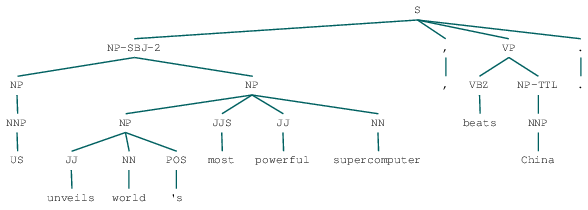

In [91]:
# visualize parse tree
result  